In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# --------------------
# Import general stuff
# --------------------
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import seaborn as sns
import itertools as it

from scipy.stats import kendalltau

from sklearn.model_selection import GroupKFold, GridSearchCV, RepeatedKFold
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from sklearn.manifold import MDS, Isomap
from sklearn.decomposition import PCA

from rdkit.Chem.AllChem import MolFromSmiles, MolToInchiKey

# ----------------------------------
# Import Retention Order SVM classes
# ----------------------------------
from rosvm.ranksvm.rank_svm_cls import KernelRankSVC
from rosvm.ranksvm.analysis_utils import RankSVMAnalyzer
from rosvm.ranksvm.tutorial.utils import read_dataset
from rosvm.feature_extraction.featurizer_cls import CircularFPFeaturizer
from rosvm.ranksvm.kernel_utils import generalized_tanimoto_kernel, minmax_kernel

## Load Example Data

We work with the seven publicly available datasets. Those include retention times measured on different chromatographic systems.

In [3]:
X, y, mol = read_dataset("./example_data_2_mol_desc.csv")  
print("Number of Measurements:", len(y))

# Number of examples per dataset
print("Datasets:")
datasets, y_cts = y.get_unique_dss(return_counts=True)
for d, c in zip(datasets, y_cts):
    print("\t%s - #samples=%d" % (d, c))
    
for _ds in y.get_unique_dss():
    assert(np.all(np.diff(y.get_idc_for_ds(_ds)) == 1))
    
mol_inchikey = [MolToInchiKey(MolFromSmiles(_m)) for _m in mol]

Number of Measurements: 1461
Datasets:
	Boudah_et_al_2014_C18 - #samples=169
	Eawag_XBridgeC18 - #samples=320
	Eugster_et_al_2015 - #samples=221
	FEM_long - #samples=299
	LIFE_new - #samples=100
	LIFE_old - #samples=96
	RIKEN - #samples=158
	UniToyama_Atlantis - #samples=98


Statistics about the classyfire molecule classes:

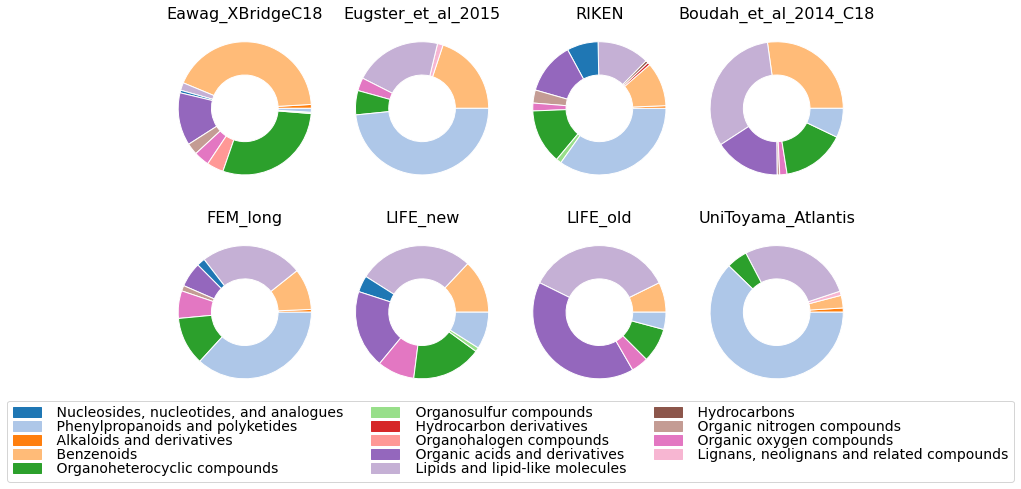

In [93]:
classyfire_df = pd.read_csv("./example_data_2_classyfire.csv", sep="\t", usecols=["dataset", "superclass", "class", "subclass"])
for r in range(len(classyfire_df)):
    isnan = np.where(classyfire_df.iloc[r].isna())[0]
    if len(isnan) > 0:
        classyfire_df.iloc[r, np.min(isnan):] = classyfire_df.iloc[r, 1]

classyfire_level = "superclass"
classes, counts = [], []
classes_set = set()

# Determine the abundancy of all classes to unify colouring
for idx, ds in enumerate(classyfire_df.dataset.unique()):
    _cls, _cts = np.unique(classyfire_df[classyfire_df.dataset == ds][classyfire_level], return_counts=True)
    classes.append(_cls)
    classes_set.update(_cls)
    counts.append(_cts)

# Get a color for each molecule class
cmap = plt.get_cmap("tab20")
colors = {_cls: _col for _cls, _col in zip(classes_set, cmap(np.arange(len(classes_set))))}

fig, axrr = plt.subplots(2, 4, figsize=(10, 6))
_h = []
for idx, ds in enumerate(classyfire_df.dataset.unique()):
    r, c = np.unravel_index(idx, axrr.shape)
    _h.append(axrr[r, c].pie(counts[idx], colors=[colors[_cls] for _cls in classes[idx]], radius=1,
                             wedgeprops=dict(width=0.5, edgecolor='w')))
    axrr[r, c].set_title(ds, fontsize=16)
    
plt.tight_layout()
plt.figlegend(handles=[mpatches.Patch(color=color, label=label) for label, color in colors.items()], 
              loc = 'lower center', ncol=3, labelspacing=0., fontsize=14, bbox_to_anchor=(0.5, -0.15))

## Build a Dataset Similarity Measure based on Molecule Classes


Instead of using the LC system's similarities augment the molecule features using the similarity of the set of molecular classes measured with a particular dataset. That means, the weighting of of features between different datasets depends on the similarity of the measured molecular classes.  

In [123]:
def minmax_kernel_from_dicts(d1, d2):
    """
    A MinMax kernel implementation using two dictionaries with counts as input.
    """
    min_k = 0
    max_k = 0
    
    k_union = set(d1.keys()) | set(d2.keys())
    
    for key in k_union:
        v1 = d1.get(key, 0)
        v2 = d2.get(key, 0)
        
        min_k += np.minimum(v1, v2)
        max_k += np.maximum(v1, v2)
        
    return np.sum(min_k) / np.sum(max_k)

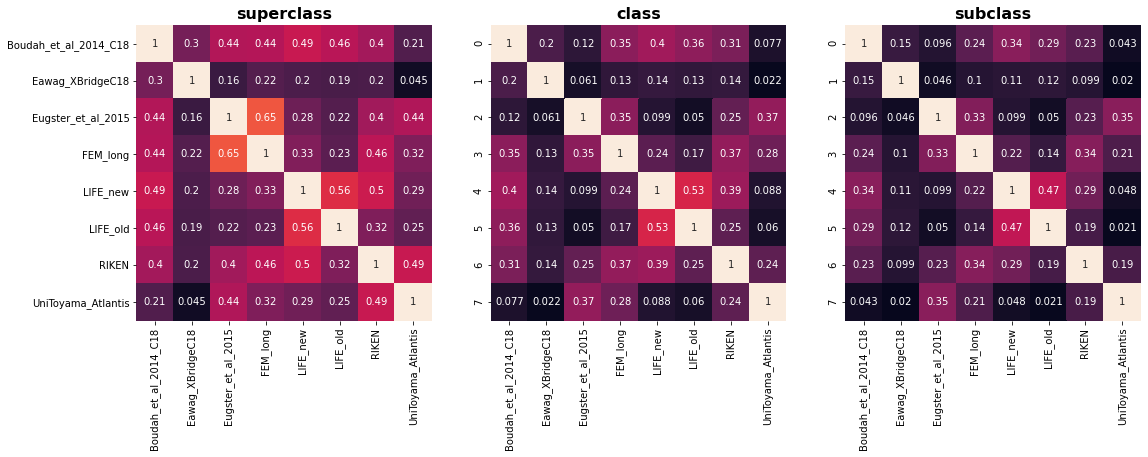

In [122]:
dss, cnts_ds = np.unique(classyfire_df.dataset, return_counts=True)
n_ds = len(dss)

K__classyfire = {
    "superclass": np.full((n_ds, n_ds), fill_value=np.nan),
    "class": np.full((n_ds, n_ds), fill_value=np.nan),
    "subclass": np.full((n_ds, n_ds), fill_value=np.nan)
}
for i, (ds1, ds2) in enumerate(it.product(dss, dss)):
    r, c = np.unravel_index(i, (n_ds, n_ds))
    
    for mcls in ["superclass", "class", "subclass"]:
        _d1 = dict(zip(*np.unique(classyfire_df[classyfire_df.dataset == ds1][mcls], return_counts=True)))
        _d2 = dict(zip(*np.unique(classyfire_df[classyfire_df.dataset == ds2][mcls], return_counts=True)))
        K__classyfire[mcls][r, c] = minmax_kernel_from_dicts(_d1, _d2)

        
fig, axrr = plt.subplots(1, 3, figsize=(18, 6))
for idx, mcls in enumerate(["superclass", "class", "subclass"]):
    if idx == 0:
        _plt_df = pd.DataFrame(K__classyfire[mcls], index=dss, columns=dss)
    else:
        _plt_df = pd.DataFrame(K__classyfire[mcls], columns=dss)
    sns.heatmap(_plt_df, annot=True, ax=axrr[idx], square=True, vmin=0, vmax=1, cbar=False)
    axrr[idx].set_title(mcls, fontsize=16, fontweight="bold")

The upper figures show the similarity between the **datasets** by their covered molecule classes. We use those kernel matrices in the following to augment the molecule features. It can be seen that similarity mainly differs between **superclass** and **class**. The **subclass** pretty much resamples the similarity based on **class**. 

In [129]:
K__superclass = np.repeat(np.repeat(K__classyfire["superclass"], cnts_ds, axis=0), cnts_ds, axis=1)
K__class = np.repeat(np.repeat(K__classyfire["class"], cnts_ds, axis=0), cnts_ds, axis=1)

assert np.all(np.repeat(dss, cnts_ds) == y.get_dss())

## Build Molecule features

We use Circular Fingerprints to extract features from the molecules.

In [168]:
from sklearn.base import clone as sk_clone
from sklearn.pipeline import FeatureUnion

base_fprinter = CircularFPFeaturizer(fp_mode="count", fp_type="ECFP", radius=5, only_freq_subs=True, min_subs_freq=0.05, output_dense_matrix=True)

## Run Evaluation

In [169]:
from joblib import Parallel, delayed

def _score(K, y, train, test, C, pair_generation):
    K_train = K[np.ix_(train, train)]
    K_test = K[np.ix_(test, train)]
    y_train = y[train]
    y_test = y[test]
    
    return KernelRankSVC(C=C, random_state=len(K_train), pair_generation=pair_generation).fit(K_train, y_train).score(K_test, y_test)

def get_ranksvm_with_optimal_C(K, y, n_splits=5, n_rep=1, pair_generation="random"):
    C_grid = 2.0 ** np.arange(-1, 5)
    
    scores = Parallel(n_jobs=4)(delayed(_score)(K, y, train, test, C, pair_generation) 
                                for (train, test), C 
                                in it.product(RepeatedKFold(n_repeats=n_rep, n_splits=n_splits, random_state=len(K)).split(y), C_grid))
    scores = np.array(scores).reshape((n_rep * n_splits, len(C_grid)))
    
    scores = np.mean(scores, axis=0)
    C_best = C_grid[np.argmax(scores)]
    
    return KernelRankSVC(C=C_best, random_state=len(K)).fit(K, y)

#### Single Dataset

In [170]:
scores_single_system = {}

for idx, ds in enumerate(y.get_unique_dss()):
    print("Dataset: '%s' (%d/%d)" % (ds, idx + 1, len(y.get_unique_dss())))
    
    # Get indices and data belonging to the current dataset
    ds_idc = y.get_idc_for_ds(ds)
    y_ds = y[ds_idc]
    mol_ds = mol[ds_idc]
    
    # Calculate the molecule features
    fprinter = sk_clone(base_fprinter).fit(mol_ds)
    X_ds = fprinter.transform(mol_ds)

    # Calculate the molecule kernel
    K_ds = minmax_kernel(X_ds, shallow_input_check=True)
    
    # Repeated KFold to evaluate the performance on the current dataset
    scores_single_system[ds] = []
    for train, test in RepeatedKFold(n_repeats=2, n_splits=5, random_state=idx).split(y_ds):        
        K_ds_train = K_ds[np.ix_(train, train)]
        K_ds_test = K_ds[np.ix_(test, train)] 
        
        scores_single_system[ds].append(get_ranksvm_with_optimal_C(K_ds_train, y_ds[train]).score(K_ds_test, y_ds[test]))    
       
    print("%.3f (+/- %.3f)" % (np.mean(scores_single_system[ds]), np.std(scores_single_system[ds])))
        
print(pd.DataFrame(scores_single_system).mean(axis=0))

Dataset: 'Boudah_et_al_2014_C18' (1/8)
0.758 (+/- 0.034)
Dataset: 'Eawag_XBridgeC18' (2/8)
0.815 (+/- 0.024)
Dataset: 'Eugster_et_al_2015' (3/8)
0.882 (+/- 0.015)
Dataset: 'FEM_long' (4/8)
0.894 (+/- 0.014)
Dataset: 'LIFE_new' (5/8)
0.814 (+/- 0.047)
Dataset: 'LIFE_old' (6/8)
0.794 (+/- 0.055)
Dataset: 'RIKEN' (7/8)
0.797 (+/- 0.032)
Dataset: 'UniToyama_Atlantis' (8/8)
0.847 (+/- 0.045)
Boudah_et_al_2014_C18    0.758114
Eawag_XBridgeC18         0.814752
Eugster_et_al_2015       0.881690
FEM_long                 0.893509
LIFE_new                 0.814007
LIFE_old                 0.794395
RIKEN                    0.796802
UniToyama_Atlantis       0.846842
dtype: float64


#### Multiple Datasets (global Fingerprints)

In [171]:
scores_muliple_systems = {}

# Calculate the molecule features
fprinter = sk_clone(base_fprinter).fit(mol)
print(len(fprinter))
X_glob = fprinter.transform(mol)

# Calculate the molecule kernel
K_glob = minmax_kernel(X_glob, shallow_input_check=True)

for idx, ds in enumerate(y.get_unique_dss()):
    print("Dataset: '%s' (%d/%d)" % (ds, idx + 1, len(y.get_unique_dss())))
    
    # Get indices and data belonging to the current dataset
    ds_idc = y.get_idc_for_ds(ds)
    y_ds = y[ds_idc]
    mol_ds = mol[ds_idc]
    
    # Repeated KFold to evaluate the performance on the current dataset
    scores_muliple_systems[ds] = []
    for _, test in RepeatedKFold(n_repeats=2, n_splits=5, random_state=idx).split(y_ds):     
        train = [_i for _i in range(len(y)) if mol[_i] not in set(mol_ds[test])]
        
        scores_muliple_systems[ds].append(get_ranksvm_with_optimal_C(K_glob[np.ix_(train, train)], y[train]) \
                                          .score(K_glob[ds_idc][np.ix_(test, train)], y_ds[test]))    
       
    print("%.3f (+/- %.3f)" % (np.mean(scores_muliple_systems[ds]), np.std(scores_muliple_systems[ds])))
        
print(pd.DataFrame(scores_muliple_systems).mean(axis=0))

122
Dataset: 'Boudah_et_al_2014_C18' (1/8)
0.841 (+/- 0.030)
Dataset: 'Eawag_XBridgeC18' (2/8)
0.820 (+/- 0.014)
Dataset: 'Eugster_et_al_2015' (3/8)
0.874 (+/- 0.015)
Dataset: 'FEM_long' (4/8)
0.903 (+/- 0.017)
Dataset: 'LIFE_new' (5/8)
0.886 (+/- 0.050)
Dataset: 'LIFE_old' (6/8)
0.887 (+/- 0.031)
Dataset: 'RIKEN' (7/8)
0.851 (+/- 0.033)
Dataset: 'UniToyama_Atlantis' (8/8)
0.863 (+/- 0.043)
Boudah_et_al_2014_C18    0.840670
Eawag_XBridgeC18         0.819772
Eugster_et_al_2015       0.874469
FEM_long                 0.903009
LIFE_new                 0.886190
LIFE_old                 0.887137
RIKEN                    0.850765
UniToyama_Atlantis       0.863333
dtype: float64


#### Multiple Datasets (local Fingerprints)

In [172]:
scores_muliple_systems_local_fps = {}

# Calculate the molecule features
fprinter = FeatureUnion(
    [
        (ds, sk_clone(base_fprinter)) 
        for ds in y.get_unique_dss()
    ]
)
for _trans_name, _trans in fprinter.transformer_list:
    _trans.fit(mol[y.get_idc_for_ds(_trans_name)])
    print(_trans_name, len(_trans))

X_glob = fprinter.transform(mol)

# Calculate the molecule kernel
K_glob = minmax_kernel(X_glob, shallow_input_check=True)

for idx, ds in enumerate(y.get_unique_dss()):
    print("Dataset: '%s' (%d/%d)" % (ds, idx + 1, len(y.get_unique_dss())))
    
    # Get indices and data belonging to the current dataset
    ds_idc = y.get_idc_for_ds(ds)
    y_ds = y[ds_idc]
    mol_ds = mol[ds_idc]
    
    # Repeated KFold to evaluate the performance on the current dataset
    scores_muliple_systems_local_fps[ds] = []
    for _, test in RepeatedKFold(n_repeats=2, n_splits=5, random_state=idx).split(y_ds):     
        train = [_i for _i in range(len(y)) if mol[_i] not in set(mol_ds[test])]
        
        scores_muliple_systems_local_fps[ds].append(get_ranksvm_with_optimal_C(K_glob[np.ix_(train, train)], y[train]) \
                                                    .score(K_glob[ds_idc][np.ix_(test, train)], y_ds[test]))    
       
    print("%.3f (+/- %.3f)" % (np.mean(scores_muliple_systems_local_fps[ds]), np.std(scores_muliple_systems_local_fps[ds])))
        
print(pd.DataFrame(scores_muliple_systems_local_fps).mean(axis=0))

Boudah_et_al_2014_C18 109
Eawag_XBridgeC18 91
Eugster_et_al_2015 185
FEM_long 164
LIFE_new 188
LIFE_old 222
RIKEN 172
UniToyama_Atlantis 407
Dataset: 'Boudah_et_al_2014_C18' (1/8)
0.831 (+/- 0.025)
Dataset: 'Eawag_XBridgeC18' (2/8)
0.823 (+/- 0.020)
Dataset: 'Eugster_et_al_2015' (3/8)
0.882 (+/- 0.014)
Dataset: 'FEM_long' (4/8)
0.902 (+/- 0.014)
Dataset: 'LIFE_new' (5/8)
0.877 (+/- 0.047)
Dataset: 'LIFE_old' (6/8)
0.877 (+/- 0.031)
Dataset: 'RIKEN' (7/8)
0.858 (+/- 0.020)
Dataset: 'UniToyama_Atlantis' (8/8)
0.858 (+/- 0.040)
Boudah_et_al_2014_C18    0.830965
Eawag_XBridgeC18         0.823441
Eugster_et_al_2015       0.882284
FEM_long                 0.901758
LIFE_new                 0.877210
LIFE_old                 0.876601
RIKEN                    0.858435
UniToyama_Atlantis       0.857602
dtype: float64


#### Multiple Datasets (with dataset-similarity, class)

In [173]:
scores_muliple_systems__class = {}

# Calculate the molecule features
fprinter = sk_clone(base_fprinter).fit(mol)
print(len(fprinter))
X_glob = fprinter.transform(mol)

# Calculate the molecule kernel
K_glob = minmax_kernel(X_glob, shallow_input_check=True) * K__class

for idx, ds in enumerate(y.get_unique_dss()):
    print("Dataset: '%s' (%d/%d)" % (ds, idx + 1, len(y.get_unique_dss())))
    
    # Get indices and data belonging to the current dataset
    ds_idc = y.get_idc_for_ds(ds)
    y_ds = y[ds_idc]
    mol_ds = mol[ds_idc]
    
    # Repeated KFold to evaluate the performance on the current dataset
    scores_muliple_systems__class[ds] = []
    for _, test in RepeatedKFold(n_repeats=2, n_splits=5, random_state=idx).split(y_ds):     
        train = [_i for _i in range(len(y)) if mol[_i] not in set(mol_ds[test])]
        
        scores_muliple_systems__class[ds].append(get_ranksvm_with_optimal_C(K_glob[np.ix_(train, train)], y[train]) \
                                                 .score(K_glob[ds_idc][np.ix_(test, train)], y_ds[test]))    
       
    print("%.3f (+/- %.3f)" % (np.mean(scores_muliple_systems__class[ds]), np.std(scores_muliple_systems__class[ds])))
        
print(pd.DataFrame(scores_muliple_systems__class).mean(axis=0))

122
Dataset: 'Boudah_et_al_2014_C18' (1/8)
0.813 (+/- 0.025)
Dataset: 'Eawag_XBridgeC18' (2/8)
0.816 (+/- 0.018)
Dataset: 'Eugster_et_al_2015' (3/8)
0.885 (+/- 0.013)
Dataset: 'FEM_long' (4/8)
0.901 (+/- 0.015)
Dataset: 'LIFE_new' (5/8)
0.866 (+/- 0.040)
Dataset: 'LIFE_old' (6/8)
0.837 (+/- 0.059)
Dataset: 'RIKEN' (7/8)
0.837 (+/- 0.026)
Dataset: 'UniToyama_Atlantis' (8/8)
0.859 (+/- 0.043)
Boudah_et_al_2014_C18    0.812657
Eawag_XBridgeC18         0.815982
Eugster_et_al_2015       0.884699
FEM_long                 0.901119
LIFE_new                 0.865608
LIFE_old                 0.836813
RIKEN                    0.837480
UniToyama_Atlantis       0.858713
dtype: float64


#### Multiple Datasets (with dataset-similarity, superclass)

In [174]:
scores_muliple_systems__superclass = {}

# Calculate the molecule features
fprinter = sk_clone(base_fprinter).fit(mol)
print(len(fprinter))
X_glob = fprinter.transform(mol)

# Calculate the molecule kernel
K_glob = minmax_kernel(X_glob, shallow_input_check=True) * K__superclass

for idx, ds in enumerate(y.get_unique_dss()):
    print("Dataset: '%s' (%d/%d)" % (ds, idx + 1, len(y.get_unique_dss())))
    
    # Get indices and data belonging to the current dataset
    ds_idc = y.get_idc_for_ds(ds)
    y_ds = y[ds_idc]
    mol_ds = mol[ds_idc]
    
    # Repeated KFold to evaluate the performance on the current dataset
    scores_muliple_systems__superclass[ds] = []
    for _, test in RepeatedKFold(n_repeats=2, n_splits=5, random_state=idx).split(y_ds):     
        train = [_i for _i in range(len(y)) if mol[_i] not in set(mol_ds[test])]
        
        scores_muliple_systems__superclass[ds].append(get_ranksvm_with_optimal_C(K_glob[np.ix_(train, train)], y[train]) \
                                                     .score(K_glob[ds_idc][np.ix_(test, train)], y_ds[test]))    
       
    print("%.3f (+/- %.3f)" % (np.mean(scores_muliple_systems__superclass[ds]), np.std(scores_muliple_systems__superclass[ds])))
        
print(pd.DataFrame(scores_muliple_systems__superclass).mean(axis=0))

122
Dataset: 'Boudah_et_al_2014_C18' (1/8)
0.819 (+/- 0.021)
Dataset: 'Eawag_XBridgeC18' (2/8)
0.818 (+/- 0.020)
Dataset: 'Eugster_et_al_2015' (3/8)
0.888 (+/- 0.013)
Dataset: 'FEM_long' (4/8)
0.902 (+/- 0.018)
Dataset: 'LIFE_new' (5/8)
0.872 (+/- 0.043)
Dataset: 'LIFE_old' (6/8)
0.842 (+/- 0.042)
Dataset: 'RIKEN' (7/8)
0.841 (+/- 0.031)
Dataset: 'UniToyama_Atlantis' (8/8)
0.866 (+/- 0.040)
Boudah_et_al_2014_C18    0.819411
Eawag_XBridgeC18         0.818179
Eugster_et_al_2015       0.887984
FEM_long                 0.902435
LIFE_new                 0.872437
LIFE_old                 0.842077
RIKEN                    0.840728
UniToyama_Atlantis       0.865906
dtype: float64


#### Multiple Datasets (with dataset-similarity, superclass, local_fps)

In [179]:
scores_muliple_systems__superclass__local_fps = {}

# Calculate the molecule features
fprinter = FeatureUnion(
    [
        (ds, sk_clone(base_fprinter)) 
        for ds in y.get_unique_dss()
    ]
)
for _trans_name, _trans in fprinter.transformer_list:
    _trans.fit(mol[y.get_idc_for_ds(_trans_name)])
    print(_trans_name, len(_trans))
    
X_glob = fprinter.transform(mol)

# Calculate the molecule kernel
K_glob = minmax_kernel(X_glob, shallow_input_check=True) * K__superclass

for idx, ds in enumerate(y.get_unique_dss()):
    print("Dataset: '%s' (%d/%d)" % (ds, idx + 1, len(y.get_unique_dss())))
    
    # Get indices and data belonging to the current dataset
    ds_idc = y.get_idc_for_ds(ds)
    y_ds = y[ds_idc]
    mol_ds = mol[ds_idc]
    
    # Repeated KFold to evaluate the performance on the current dataset
    scores_muliple_systems__superclass__local_fps[ds] = []
    for _, test in RepeatedKFold(n_repeats=2, n_splits=5, random_state=idx).split(y_ds):     
        train = [_i for _i in range(len(y)) if mol[_i] not in set(mol_ds[test])]
        
        scores_muliple_systems__superclass__local_fps[ds].append(get_ranksvm_with_optimal_C(K_glob[np.ix_(train, train)], y[train]) \
                                                                 .score(K_glob[ds_idc][np.ix_(test, train)], y_ds[test]))    
       
    print("%.3f (+/- %.3f)" % (np.mean(scores_muliple_systems__superclass__local_fps[ds]),
                               np.std(scores_muliple_systems__superclass__local_fps[ds])))
        
print(pd.DataFrame(scores_muliple_systems__superclass__local_fps).mean(axis=0))

Boudah_et_al_2014_C18 109
Eawag_XBridgeC18 91
Eugster_et_al_2015 185
FEM_long 164
LIFE_new 188
LIFE_old 222
RIKEN 172
UniToyama_Atlantis 407
Dataset: 'Boudah_et_al_2014_C18' (1/8)
0.818 (+/- 0.021)
Dataset: 'Eawag_XBridgeC18' (2/8)
0.814 (+/- 0.022)
Dataset: 'Eugster_et_al_2015' (3/8)
0.893 (+/- 0.013)
Dataset: 'FEM_long' (4/8)
0.903 (+/- 0.016)
Dataset: 'LIFE_new' (5/8)
0.869 (+/- 0.045)
Dataset: 'LIFE_old' (6/8)
0.837 (+/- 0.047)
Dataset: 'RIKEN' (7/8)
0.845 (+/- 0.026)
Dataset: 'UniToyama_Atlantis' (8/8)
0.859 (+/- 0.038)
Boudah_et_al_2014_C18    0.817991
Eawag_XBridgeC18         0.814253
Eugster_et_al_2015       0.892929
FEM_long                 0.903005
LIFE_new                 0.869290
LIFE_old                 0.836817
RIKEN                    0.844567
UniToyama_Atlantis       0.859298
dtype: float64


In [180]:
pd.concat(
    (
        pd.DataFrame(scores_single_system).aggregate(lambda x: "%.2f (+/- %.2f)" % (np.mean(x), np.std(x))),
        pd.DataFrame(scores_muliple_systems).aggregate(lambda x: "%.2f (+/- %.2f)" % (np.mean(x), np.std(x))),
        pd.DataFrame(scores_muliple_systems_local_fps).aggregate(lambda x: "%.2f (+/- %.2f)" % (np.mean(x), np.std(x))),
        pd.DataFrame(scores_muliple_systems__superclass).aggregate(lambda x: "%.2f (+/- %.2f)" % (np.mean(x), np.std(x))),
        pd.DataFrame(scores_muliple_systems__class).aggregate(lambda x: "%.2f (+/- %.2f)" % (np.mean(x), np.std(x))),
        pd.DataFrame(scores_muliple_systems__superclass__local_fps).aggregate(lambda x: "%.2f (+/- %.2f)" % (np.mean(x), np.std(x)))
    ),
    axis=1
).rename({0: "Single System", 1: "Multi System", 2: "Multi System (local fps)", 3: "Multi System (* superclass)",
          4: "Multi System (* class)", 5: "Multi System (* superclass, local fps)"}, axis=1)

,Single System,Multi System,Multi System (local fps),Multi System (* superclass),Multi System (* class),"Multi System (* superclass, local fps)"
Boudah_et_al_2014_C18,0.76 (+/- 0.03),0.84 (+/- 0.03),0.83 (+/- 0.03),0.82 (+/- 0.02),0.81 (+/- 0.03),0.82 (+/- 0.02)
Eawag_XBridgeC18,0.81 (+/- 0.02),0.82 (+/- 0.01),0.82 (+/- 0.02),0.82 (+/- 0.02),0.82 (+/- 0.02),0.81 (+/- 0.02)
Eugster_et_al_2015,0.88 (+/- 0.01),0.87 (+/- 0.02),0.88 (+/- 0.01),0.89 (+/- 0.01),0.88 (+/- 0.01),0.89 (+/- 0.01)
FEM_long,0.89 (+/- 0.01),0.90 (+/- 0.02),0.90 (+/- 0.01),0.90 (+/- 0.02),0.90 (+/- 0.02),0.90 (+/- 0.02)
LIFE_new,0.81 (+/- 0.05),0.89 (+/- 0.05),0.88 (+/- 0.05),0.87 (+/- 0.04),0.87 (+/- 0.04),0.87 (+/- 0.05)
LIFE_old,0.79 (+/- 0.06),0.89 (+/- 0.03),0.88 (+/- 0.03),0.84 (+/- 0.04),0.84 (+/- 0.06),0.84 (+/- 0.05)
RIKEN,0.80 (+/- 0.03),0.85 (+/- 0.03),0.86 (+/- 0.02),0.84 (+/- 0.03),0.84 (+/- 0.03),0.84 (+/- 0.03)
UniToyama_Atlantis,0.85 (+/- 0.04),0.86 (+/- 0.04),0.86 (+/- 0.04),0.87 (+/- 0.04),0.86 (+/- 0.04),0.86 (+/- 0.04)
